## Week 1: Recap
- What is a machine learning algorithm?
    - Algorithm that improves performance (P) on a task (T) via experience (E)
- Types of machine learning tasks
- Supervised vs unsupervised learning
- Generalization, overfitting, and underfitting
- Bias and variance
- Regularization and hyperparameters

## Week 2: Outline
- Gentle introduction with linear regression
    - Cost/objective functions
    - Analytical vs numerical solutions
- Maximum likelihood estimation
    - Estimators
    - Likelihood vs probability
    - Maximum likelihood estimators

## Part I: Linear Regression
Linear regression is a machine learning algorithm that makes predictions about the linear relationship between the indepenedent variable $x$ and the dependent variable $y$. The algorithm takes a vector $x \in \mathbb{R}$ as an input and predict the value of a scalar $y \in \mathbb{R}$ as an output. 
$$\hat{y} = w^Tx$$
where $\hat{y}$ is the predicted value of $y$ and $w$ is a vector of parameters (aka weights). 

**How do we choose $w$?**
We need a way to evaluate performance!

### Mean squared error (MSE)
A common method is to compute the average error of the model on the $m$ true values of $y$ in the test set. 
$$ \textrm{MSE}_{\textrm{test}} = \frac{1}{m}\sum_i(\hat{y}_i-y_i)^2$$

In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

np.random.seed(44)

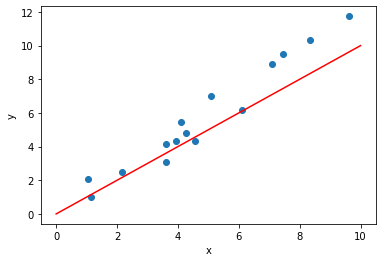

In [2]:
# generate some noisy data
n_samples = 15
w_true = 1.2
x = np.random.rand(n_samples)*10
noise = norm.rvs(0,1,x.shape) # the original code used uniform noise
y = w_true*x + noise

ax = plt.subplot(1,1,1)
ax.scatter(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')

# linear regression model
x_axis = np.linspace(0,10,20)
w = 1 # our guess for the value of w
y_hat = w*x_axis
ax.plot(x_axis, y_hat, color='red');

In [3]:
def compute_mse(x, y, w):
    """function that computes mean squared error"""
    y_hat = w*x
    mse = np.mean((y - y_hat)**2)
    return mse

Now let's evaluate the MSE of three different models (values of $w$)

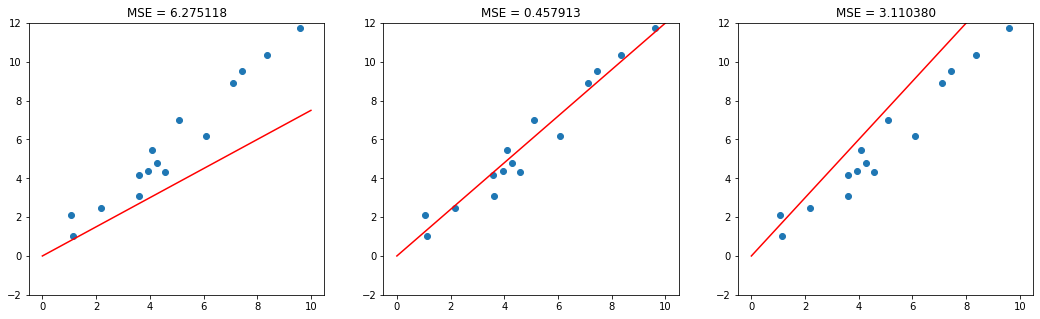

In [4]:
w = [0.75, w_true, 1.5]

fig, ax = plt.subplots(1, 3, figsize=(18,5))

for i in range(3):
    ax[i].scatter(x, y)
    ax[i].plot(x_axis, w[i]*x_axis, color='red')
    ax[i].set_ylim(-2,12)
    ax[i].set_title('MSE = %f' % compute_mse(x,y,w[i]));

We still haven't answered our question: **How do we choose $w$?**

The key is to think of MSE as a **cost function.**

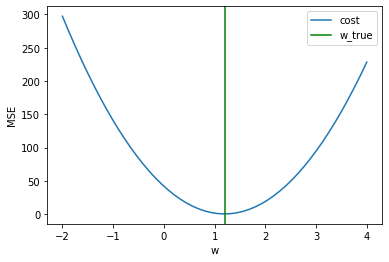

In [5]:
n_points = 50
all_w = np.linspace(-2,4,n_points)
mse = np.zeros((n_points))
for i in range(n_points):
    mse[i] = compute_mse(x, y, all_w[i])

plt.plot(all_w,mse)
plt.xlabel('w')
plt.ylabel('MSE')
plt.axvline(w_true, color='green')
plt.legend(['cost','w_true']);

**How do we choose $w$?** Minimize the cost function!

To minimize MSE, we solve for where its gradient is 0:

$$\nabla_w\textrm{MSE} = 0$$
$$\nabla_w\frac{1}{m}\sum_i(\hat{y}_i-y_i)^2 = 0$$
$$ ... $$
$$w = (X^TX)^{-1}X^Ty$$

This is known as solving the *normal equations* (see [Deep Learning 5.1.4](http://www.deeplearningbook.org/contents/ml.html) for more details).

In [6]:
def solve_normal_eqn(x,y):
    """Function that solves the normal equations to produce the 
    value of w that minimizes MSE"""
    
    # our numpy arrays are 0-dimensional by default- for the
    # transpose/dot product/inverse to work, we reshape them
    m = len(x)
    x = np.reshape(x, (m, 1))
    y = np.reshape(y, (m, 1))

    w = np.dot(np.dot(np.linalg.inv(x.T.dot(x)),x.T),y)
    
    return w

In [7]:
solve_normal_eqn(x,y)

array([[1.19769016]])

## Part I: Summary
- Linear regression is a simple machine learning algorithm:
    - Task: predict a value for $y$ given $x$
    - Performance measure: $\textrm{MSE}_{\textrm{test}}$
    - Experience: minimize $\textrm{MSE}_{\textrm{test}}$ by solving the normal equations
- **Key point**: We fit the model by defining an **objective function** (aka **cost function**) and minimizing it. 
- **Key point**: Sometimes (as with simple linear regression), we can solve the optimization *analytically*. What if it can't be solved?

### Extensions:
- Implement an intercept for our linear regression model (hint: pad the X matrix with 1s)
- We ignored the use of training and test sets
- Solve the gradient of MSE yourself

## Part II: Maximum Likelihood Estimation
### What is a likelihood?
Let's say we have a single lonely data point $x$ sampled from one of two candidate normal distributions $f_1=\mathcal{N}(\theta_1)$ and $f_2=\mathcal{N}(\theta_2)$ where $\theta_1 = \{\mu_1,\sigma_1\}$ and $\theta = \{\mu_2, \sigma_2\}$.

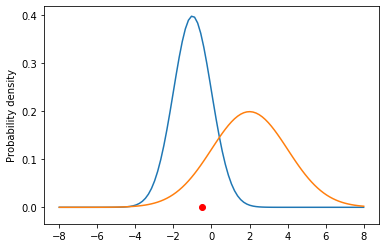

In [8]:
x = -0.5
mu1, sig1 = -1, 1
mu2, sig2 = 2, 2
x_axis = np.linspace(-8,8,100)
f1 = norm.pdf(x_axis, mu1, sig1)
f2 = norm.pdf(x_axis, mu2, sig2)

ax = plt.subplot(111)
ax.scatter(x, 0, color='red');
ax.plot(x_axis, f1);
ax.plot(x_axis, f2);
ax.set_ylabel('Probability density');

How do we determine which candidate distribution is more likely given the single data point $x$?

The **likelihood** that data $x$ was generated by some continuous distribution $f$ parameterized by $\theta$ can be written: 
$$\mathcal{L}(\theta | x) = f(x | \theta)$$
In the discrete case, we can write:
$$\mathcal{L}(\theta | x) = P(x | \theta)$$


For our normal example with scalar $x$, the likelihood is given by the Gaussian probability density function:

$$\mathcal{L}(\theta | x) = \mathcal{N}(\theta)$$

$$\mathcal{L}(\theta | x) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp(-\frac{(x-\mu)^2}{2\sigma^2})$$

L(theta1|x) = 0.352065
L(theta2|x) = 0.091325


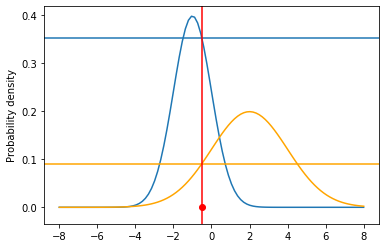

In [9]:
prob1 = norm.pdf(x, mu1, sig1)
prob2 = norm.pdf(x, mu2, sig2)
print('L(theta1|x) = %f' % prob1)
print('L(theta2|x) = %f' % prob2)

ax = plt.subplot(111)
ax.scatter(x, 0, color='red');
ax.plot(x_axis, f1);
ax.plot(x_axis, f2, color='orange');
ax.axhline(prob1)
ax.axhline(prob2, color='orange')
ax.axvline(x, color='red')
ax.set_ylabel('Probability density');

### Probability vs likelihood

If $\mathcal{L}(\theta|x) = P(x|\theta)$, then what's the difference?

- Think of **probability** relating to possible **results**
- Think of **likelihood** relating to **hypotheses**

What if we had two data points?

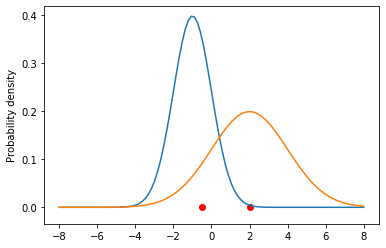

In [10]:
x = [-0.5, 2]

ax = plt.subplot(111)
ax.scatter(x, [0, 0], color='red')
ax.plot(x_axis, f1)
ax.plot(x_axis, f2)
ax.set_ylabel('Probability density')
plt.show()

In [11]:
prob1 = norm.pdf(x[0], mu1, sig1)*norm.pdf(x[1], mu1, sig1)
prob2 = norm.pdf(x[0], mu2, sig2)*norm.pdf(x[1], mu2, sig2)
print('L(theta1|x) = %f' % prob1)
print('L(theta2|x) = %f' % prob2)

L(theta1|x) = 0.001560
L(theta2|x) = 0.018217


Note that observing another data point means that the orange distribution is now more likely to have generated $X$. What if we had much more data?

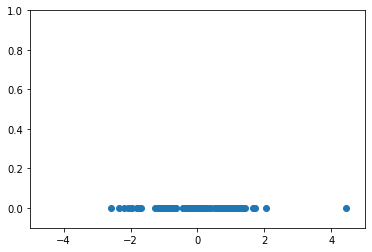

In [12]:
# generate normally distributed samples
mu_true = 0
sig_true = 1
n_samples = 100
x = norm.rvs(mu_true, sig_true, n_samples)
plt.scatter(x,np.zeros(x.shape));
plt.xlim(-5,5)
plt.ylim(-0.1,1);

**Maximum likelihood is a flexible cost function.**

We can also think of the likelihood $\mathcal{L}$ as the probability that a model would produce the data ($P_{\textrm{model}}$). If we assume that $m$ data points $X = \{x_1,...,x_m\}$ are produced by a model $P_{\textrm{model}}(X | \theta)$, we can use the likelihood to maximize the probability that the data were generated from the model:

$$\hat{\theta}_{\textrm{ML}} = \underset{\theta}{\operatorname{argmax}}P_{\textrm{model}}(X | \theta)$$

$$\hat{\theta}_{\textrm{ML}} = \underset{\theta}{\operatorname{argmax}}\prod_{i=1}^m P_{\textrm{model}}(x_i | \theta)$$

For reasons of numerical stability, we take the logarithm of the likelihood:

$$\hat{\theta}_{\textrm{ML}} = \underset{\theta}{\operatorname{argmax}}\sum_{i=1}^m \textrm{log}P_{\textrm{model}}(x_i | \theta)$$

This turns all products into sums so we can avoid multiplying very low probabilities, which can lead to *underflow* when many data points are being evaluated. 

The $\textrm{log}()$ function is *monotonically increasing*, which means that it preserves the order of its inputs. Therefore solving the $\textrm{log}$-transformed equation is equivalent to solving the original:
$$\underset{\theta}{\operatorname{argmax}}\prod_{i=1}^m P_{\textrm{model}}(x_i | \theta) = \underset{\theta}{\operatorname{argmax}}\sum_{i=1}^m \textrm{log}P_{\textrm{model}}(x_i | \theta)$$


In the Gaussian case, the loglikelihood is given by:

$$\mathcal{L}(\mu, \sigma | X) = \prod_{i=1}^m\frac{1}{\sqrt{2\pi\sigma^2}}\exp(-\frac{(x_i-\mu)^2}{2\sigma^2})$$
$$\textrm{log}\mathcal{L}(\mu, \sigma | x) = \sum_{i=1}^m\textrm{log}\frac{1}{\sqrt{2\pi\sigma^2}}\exp(-\frac{(x_i-\mu)^2}{2\sigma^2})$$

In [13]:
def compute_ll(x, mu, sig):
    """function that computes the log likelihood of a gaussian"""
    ll = np.sum(norm.logpdf(x, mu, sig))
    return ll

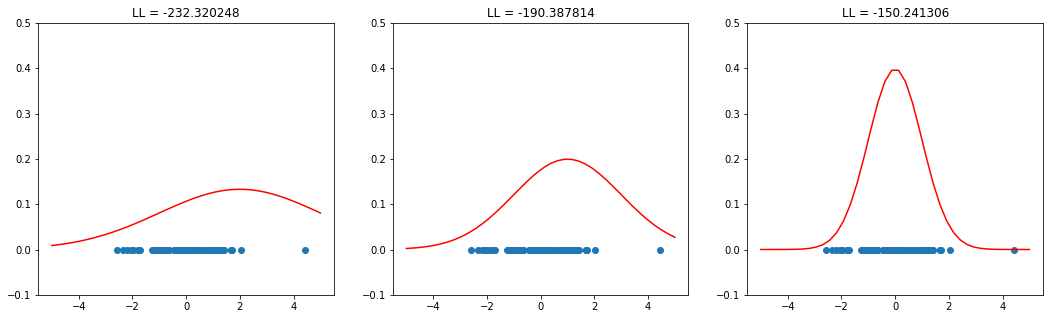

In [14]:
x_axis = np.linspace(-5,5,40)
mu = [2, 1, mu_true]
sig = [3, 2, sig_true]
fig, ax = plt.subplots(1, 3, figsize=(18,5))

for i in range(3):
    ax[i].scatter(x,np.zeros(x.shape))
    ax[i].set_ylim(-0.1,0.5)
    ax[i].plot(x_axis, norm.pdf(x_axis, mu[i], sig[i]), color='red')
    ax[i].set_title('LL = %f' % compute_ll(x,mu[i],sig[i]))

The normal distribution has two parameters $\mu$ and $\sigma$, and the loglikelihood is a function of both. The LL can now be visualized as a 3-dimensional LL "surface."

In [15]:
# parameter space to plot
precision = 20
mu_space = np.linspace(-3,3,precision)
sig_space = np.linspace(0.5,1.5,precision)

MU, SIG = np.meshgrid(mu_space, sig_space)
LL = np.zeros(MU.shape)

# compute LL for parameter space
for i in range(precision):
    for ii in range(precision):
        LL[i,ii] = compute_ll(x, mu_space[i], sig_space[ii])

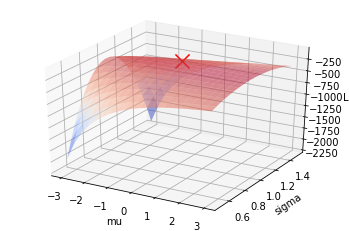

In [16]:
# note- I haven't figured out a good way to make this 3d 
# fig interactive.. if you know how, let me know!

# plot LL surface
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(MU, SIG, LL, cmap=cm.coolwarm,
                       linewidth=0, alpha=0.5)

# plot max
ind = np.unravel_index(np.argmax(LL, axis=None), LL.shape)
ax.scatter(mu_space[ind[0]], sig_space[ind[1]], LL[ind], s=200, 
          color='red', marker='x')
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
ax.set_zlabel('LL');

The likelihood of a Gaussian is analytically tractable- we can take the gradient and solve for the maximum likelihood parameters. Leaving out the steps, the maximum likelihood estimate for $\mu$ is given by:

$$\nabla_{\mu}\textrm{log}\mathcal{L}(\mu, \theta | X) = 0$$
$$ ... $$
$$\hat{\mu}_{\textrm{ML}} = \sum_{i=1}^m\frac{x_i}{m}$$

Note that this is the formula for the sample mean $\bar{\mu}$! This means that the sample mean of $X$ is the estimate for $\mu$ that maximizes the probability of observing $X$. 

Similarly for $\sigma$:
$$\nabla_{\sigma}\textrm{log}\mathcal{L}(\mu, \theta | X) = 0$$
$$...$$
$$\hat{\sigma}_{\textrm{ML}}^2 = \frac{1}{m}\sum_{i=1}^m(x_i - \mu)^2$$
This equation should also be familiar. Hopefully this gives some intuition for what it means to say that an estimator is a "maximum likelihood estimator."

## Part II: Summary
- Likelihood vs probability
    - $\mathcal{L}(\theta|X) = P(X|\theta)$
    - $P(X|\theta)$ -> "probability of observing $X$ given $\theta$"
    - $\mathcal{L}(\theta|X)$ -> "likelihood that parameters $\theta$ produced $X$"
- Log-likelihood maximization
    - We take the $\textrm{log}$ of the likelihood function for computational convenience
    - The parameters $\theta$ that maximize $\textrm{log}\mathcal{L}(\theta|X)$ are the model parameters that maximize the probability of observing the data
- **Key point**: The log-likelihood is a flexible cost function, and is often used to find model parameters that best fit the data
- **Key point**: If the log-likelihood function is differentiable, we can analytically solve for maximum likelihood parameter estimates

### Extensions:
- Minimizing mean squared error (MSE) can be shown to be mathematically equivalent to maximizing log-likelihood. See if you can show this analytically.
- Derive the maximum likelihood estimators for $\mu$ and $\sigma^2$ shown above yourself

### Next week:
- So far, we have only considered cases where the cost function is diffentiable. In practice, this is almost never the case. 
- Next week we will use numerical optimization to fit some more complex models. 